In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , accuracy_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MYCOM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MYCOM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Getting the Training Data

In [2]:
df = pd.read_csv("Genre Classification Dataset/train_data.txt", sep='\t', on_bad_lines='skip')
df.head()

,"1 ::: Oscar et la dame rose (2009) ::: drama ::: Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue."
0,2 ::: Cupid (1997) ::: thriller ::: A brother ...
1,"3 ::: Young, Wild and Wonderful (1980) ::: adu..."
2,4 ::: The Secret Sin (1915) ::: drama ::: To h...
3,5 ::: The Unrecovered (2007) ::: drama ::: The...
4,6 ::: Quality Control (2011) ::: documentary :...


In [3]:
train_data = pd.read_csv("Genre Classification Dataset/train_data.txt", sep=":::", names=["Title", "Genre", "Description"],
                         on_bad_lines='skip', engine="python")
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
train_data.shape

(54214, 3)

In [5]:
train_data.isna().sum()

Title          0
Genre          0
Description    0
dtype: int64

### Getting the Testing Data

In [6]:
test_data = pd.read_csv("Genre Classification Dataset/test_data.txt", sep=":::", names=["Title", "Description"], engine="python")
test_data.head()

,Title,Description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


# --------------------------------------------------------------------------------------

In [7]:
train_data['length']=train_data['Description'].apply(len)
train_data.head()

,Title,Genre,Description,length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


In [8]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'.pic\S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)  # Change to replace non-characters with a space
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    # Use the predefined stop_words variable instead of redefining it inside the function
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    text = re.sub(r"\s+", " ", text).strip()  # Replace multiple spaces with a single space
    return text

train_data["TextCleaning"] = train_data["Description"].apply(data_processing)
test_data["TextCleaning"] = test_data["Description"].apply(data_processing)

In [9]:
train_data

,Title,Genre,Description,length,TextCleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,film title refers recovered bodies ground zero...
...,...,...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,507,short lived nbc live sitcom centered bonino wo...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,781,next generation exploitation sisters kapa bay ...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",255,bestaan echt stand comedy growing facing fears...
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,642,walter vivian live country difficult time keep...


### Analysis

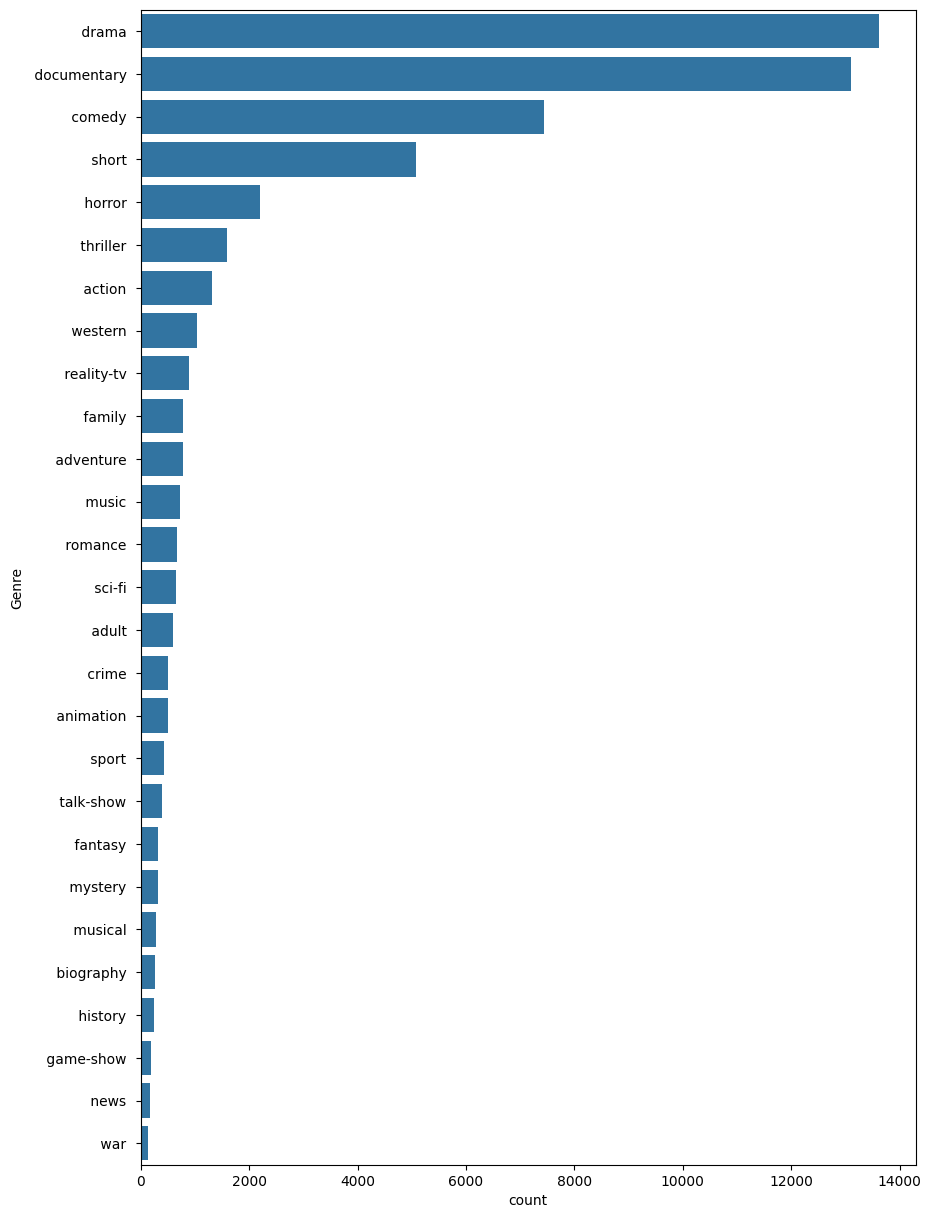

In [18]:
plt.figure(figsize=(10,15))
sns.countplot(data=train_data, y="Genre", order= train_data["Genre"].value_counts().index)
plt.show()

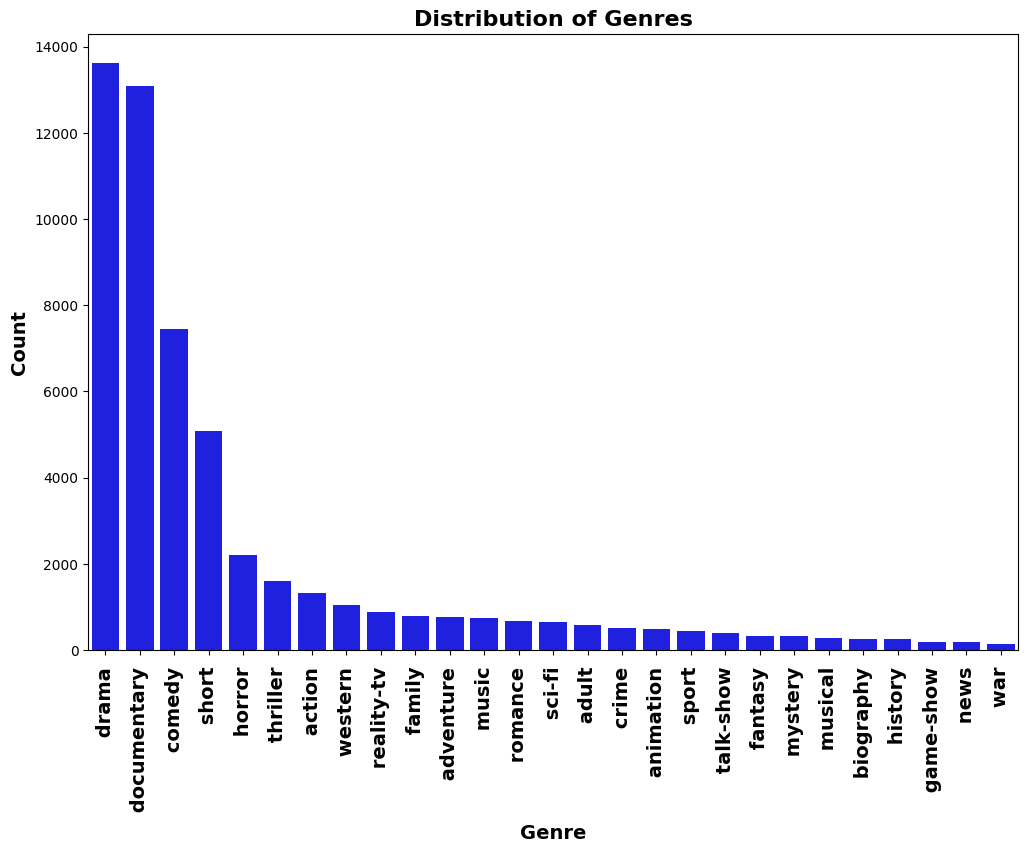

In [19]:
plt.figure(figsize=(12,8))
counts = train_data.Genre.value_counts()
sns.barplot(x=counts.index, y=counts, color='blue')
plt.xlabel('Genre' ,fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold');

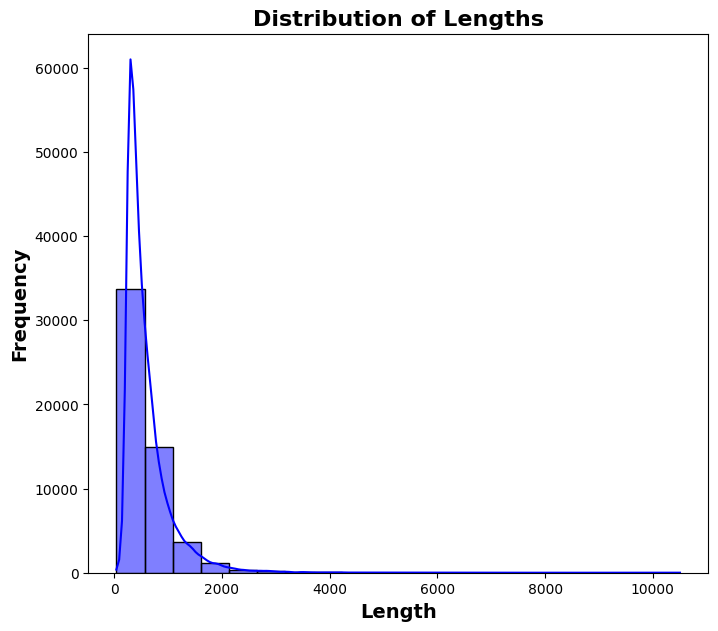

In [20]:
plt.figure(figsize=(8, 7))

sns.histplot(data=train_data, x='length', bins=20, kde=True, color='blue')

plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')

plt.show()

### Using TF-IDF to vectorize the data

In [10]:
vector = TfidfVectorizer()

x_train = vector.fit_transform(train_data["TextCleaning"])
x_test = vector.transform(test_data["TextCleaning"])

In [11]:
x = x_train
y = train_data["Genre"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)

### Train the model

In [12]:
model1 = LogisticRegression()
model2 = MultinomialNB()

In [13]:
columns=['LogisticRegression','SVC','MultinomialNB']
result=[]

In [14]:
def cal(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_pred,y_test)
    result.append(accuracy)
    
    print(model)
    print(accuracy)

In [15]:
cal(model1)

LogisticRegression()
0.577792123950936


In [16]:
cal(model2)

MultinomialNB()
0.4460942543576501


In [17]:
test_data_solution = pd.read_csv("Genre Classification Dataset/test_data_solution.txt", sep=":::", names=["Title", "Genre", "Description"], engine="python")
test_data_solution.head()

,Title,Genre,Description
1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),drama,Before he was known internationally as a mart...
